# 03 Marker Geometry Analysis

This notebook analyzes the geometry of **trajectory realizations in marker space** to support a **physics-aware, diversity-oriented directed sampling strategy**.

Scope:
- Analysis only (no model retraining, no dataset regeneration).
- Reuse existing repository loaders and dataset artifacts.
- Assume smooth dynamics (small-signal regime), focusing on redundancy and coverage.


## 1) Setup and Existing Dataset Loading


In [1]:
from __future__ import annotations

import itertools
import sys
from pathlib import Path
from typing import Any

PROJECT_ROOT = Path.cwd()
if not (PROJECT_ROOT / "src").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from omegaconf import OmegaConf
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

from src.data.preprocessed_trajectory_loader import load_trajectory_dataset_from_preprocessed
from src.data.raw_trajectory_loader import load_train_arrays_from_raw

plt.style.use("default")
pd.set_option("display.max_columns", 300)
np.set_printoptions(suppress=True, precision=5)


In [2]:
# User configuration
MODEL_FLAG = "SM4"                  # e.g. SM4, SM6, SM_AVR_GOV
DATASET_NUMBER = None                # None -> auto-pick latest dataset_vN under data/{MODEL_FLAG}
MAX_TRAJECTORIES = 6000              # None for all, or set for faster analysis
RANDOM_SEED = 42
PREFER_RAW_WHEN_AVAILABLE = True
DROP_REDUNDANT_MARKERS = False       # optional pruning after correlation analysis
REDUNDANCY_THRESHOLD = 0.90          # |rho| > threshold considered redundant

# Clustering and sampling settings
K_RANGE = list(range(4, 9))
SAMPLING_N_VALUES = [16, 32, 64, 128, 256, 512]
DENSITY_K = 15


In [3]:
def load_model_state_info(model_flag: str, init_conditions_dir: Path | None = None) -> dict[str, Any]:
    if init_conditions_dir is None:
        init_conditions_dir = PROJECT_ROOT / "src/conf/ic"
    guide_path = init_conditions_dir / "modellings_guide.yaml"
    if not guide_path.exists():
        raise FileNotFoundError(f"Modeling guide not found: {guide_path}")

    guide = OmegaConf.load(str(guide_path))
    for item in guide:
        if item.get("name") == model_flag:
            keys = list(item.get("keys"))
            keys_ext = list(item.get("keys_ext")) if item.get("keys_ext") is not None else []
            return {
                "keys": keys,
                "keys_ext": keys_ext,
                "full_name": item.get("full_name", model_flag),
            }
    raise ValueError(f"Model '{model_flag}' not found in {guide_path}")


def detect_dataset_layout(dataset_root: Path) -> dict[str, bool]:
    raw_dir = dataset_root / "raw"
    train_dir = dataset_root / "train"
    test_dir = dataset_root / "test"

    has_raw = raw_dir.exists() and any(raw_dir.glob("*.pkl"))
    has_pre = (
        train_dir.exists()
        and test_dir.exists()
        and any(train_dir.glob("*data*.h5"))
        and any(test_dir.glob("*data*.h5"))
    )
    return {"has_raw": has_raw, "has_preprocessed": has_pre}


def find_latest_dataset_number(dataset_dir: Path, model_flag: str) -> int:
    model_root = dataset_dir / model_flag
    if not model_root.exists():
        raise FileNotFoundError(f"Model dataset directory not found: {model_root}")

    candidates = []
    for p in model_root.glob("dataset_v*"):
        suffix = p.name.replace("dataset_v", "")
        if suffix.isdigit():
            candidates.append(int(suffix))
    if not candidates:
        raise FileNotFoundError(f"No dataset_vN folders found under: {model_root}")
    return max(candidates)


def load_dataset_auto(
    dataset_dir: Path,
    model_flag: str,
    dataset_number: int,
    max_trajectories: int | None = None,
    prefer_raw: bool = True,
    seed: int = 0,
) -> dict[str, Any]:
    dataset_root = dataset_dir / model_flag / f"dataset_v{dataset_number}"
    if not dataset_root.exists():
        raise FileNotFoundError(f"Dataset root not found: {dataset_root}")

    layout = detect_dataset_layout(dataset_root)
    if not layout["has_raw"] and not layout["has_preprocessed"]:
        raise ValueError(f"No raw PKL or preprocessed H5 found in {dataset_root}")

    loaded = False
    x_ics = y_trajs = t = None
    source = None

    if layout["has_raw"] and (prefer_raw or not layout["has_preprocessed"]):
        try:
            x_ics, y_trajs, t = load_train_arrays_from_raw(
                dataset_dir=str(dataset_dir),
                init_conditions_dir=str(PROJECT_ROOT / "src/conf/ic"),
                model_flag=model_flag,
                dataset_number=dataset_number,
                shuffle=False,  # preserve existing order to compare with LHS ordering proxy
                seed=seed,
                max_samples=max_trajectories,
            )
            source = "raw"
            loaded = True
        except Exception as exc:
            if not layout["has_preprocessed"]:
                raise
            print(f"Raw loading failed ({exc}); falling back to preprocessed.")

    if not loaded:
        ds = load_trajectory_dataset_from_preprocessed(
            dataset_dir=str(dataset_dir),
            model_flag=model_flag,
            dataset_number=dataset_number,
            include_val_in_train=True,
        )
        x_train, y_train = ds.training_view()
        x_test, y_test = ds.test_view()

        if x_test is None or y_test is None:
            x_ics, y_trajs = x_train, y_train
        else:
            x_ics = np.concatenate([x_train, x_test], axis=0)
            y_trajs = np.concatenate([y_train, y_test], axis=0)

        if max_trajectories is not None:
            x_ics = x_ics[:max_trajectories]
            y_trajs = y_trajs[:max_trajectories]

        t = ds.time_grid
        source = "preprocessed"

    if t is None:
        raise ValueError("Could not infer a shared time grid.")

    return {
        "ics": np.asarray(x_ics, dtype=np.float32),
        "trajs": np.asarray(y_trajs, dtype=np.float32),
        "time": np.asarray(t, dtype=np.float32),
        "source": source,
        "layout": layout,
        "dataset_root": dataset_root,
    }


In [4]:
DATA_DIR = PROJECT_ROOT / "data"
if DATASET_NUMBER is None:
    DATASET_NUMBER = find_latest_dataset_number(DATA_DIR, MODEL_FLAG)

state_info = load_model_state_info(MODEL_FLAG)
state_names = state_info["keys"]
ext_names = state_info["keys_ext"]
ic_names = state_names + ext_names

dataset = load_dataset_auto(
    dataset_dir=DATA_DIR,
    model_flag=MODEL_FLAG,
    dataset_number=DATASET_NUMBER,
    max_trajectories=MAX_TRAJECTORIES,
    prefer_raw=PREFER_RAW_WHEN_AVAILABLE,
    seed=RANDOM_SEED,
)

ics = dataset["ics"]
trajs = dataset["trajs"]
time_grid = dataset["time"]

n_traj, n_time, n_states = trajs.shape
if len(state_names) != n_states:
    state_names = [f"x{i}" for i in range(n_states)]
if len(ic_names) != ics.shape[1]:
    ic_names = [f"ic{i}" for i in range(ics.shape[1])]

print(f"Dataset root: {dataset['dataset_root']}")
print(f"Source used: {dataset['source']} | layout={dataset['layout']}")
print(f"Trajectories: {n_traj}")
print(f"Trajectory shape: (N={n_traj}, T={n_time}, S={n_states})")
print(f"IC shape: {ics.shape}")
print(f"Time span: [{time_grid[0]:.4f}, {time_grid[-1]:.4f}] with {len(time_grid)} points")


Dataset root: /Users/jonaswiendl/local/Repos/ml-surrogates-for-power-systems/data/SM4/dataset_v2
Source used: raw | layout={'has_raw': True, 'has_preprocessed': True}
Trajectories: 2400
Trajectory shape: (N=2400, T=1001, S=4)
IC shape: (2400, 6)
Time span: [0.0000, 1.0000] with 1001 points


## 2) Compute Trajectory Markers

Markers are computed in reusable, modular functions and then assembled into a marker matrix of shape `(num_trajectories, num_markers)`.

Marker families:
- A) Amplitude/scale
- B) Time-scale/damping
- C) Activity/curvature


In [5]:
def _statewise_peak_abs(x: np.ndarray) -> np.ndarray:
    # (N, T, S) -> (N, S)
    return np.max(np.abs(x), axis=1)


def _statewise_range(x: np.ndarray) -> np.ndarray:
    # (N, T, S) -> (N, S)
    return np.max(x, axis=1) - np.min(x, axis=1)


def _trajectory_energy(x: np.ndarray, t: np.ndarray) -> np.ndarray:
    # Integral of ||x(t)||_2^2 dt for each trajectory -> (N,)
    norm_sq = np.sum(x**2, axis=2)
    return np.trapezoid(norm_sq, x=t, axis=1)


def _statewise_settling_time(x: np.ndarray, t: np.ndarray, frac: float = 0.05) -> np.ndarray:
    # Approximate settling time: first time after which trajectory stays within frac*range of final value.
    final = x[:, -1:, :]                        # (N,1,S)
    amp = np.max(x, axis=1) - np.min(x, axis=1)  # (N,S)
    threshold = np.maximum(frac * amp[:, None, :], 1e-8)
    err = np.abs(x - final)
    within = err <= threshold

    n, tt, s = within.shape
    out = np.empty((n, s), dtype=np.float32)
    for i in range(n):
        for j in range(s):
            ok = within[i, :, j]
            # condition "stays within" implemented via suffix all-true mask
            suffix_ok = np.flip(np.cumprod(np.flip(ok.astype(np.int32)))) > 0
            idx = np.where(suffix_ok)[0]
            out[i, j] = t[idx[0]] if idx.size > 0 else t[-1]
    return out


def _statewise_iae(x: np.ndarray, t: np.ndarray) -> np.ndarray:
    # Integral absolute error w.r.t. final value for each state -> (N,S)
    final = x[:, -1:, :]
    return np.trapezoid(np.abs(x - final), x=t, axis=1)


def _statewise_total_variation(x: np.ndarray) -> np.ndarray:
    # Sum_t |x(t+1)-x(t)| for each state -> (N,S)
    return np.sum(np.abs(np.diff(x, axis=1)), axis=1)


def _trajectory_derivative_l2_energy(x: np.ndarray, t: np.ndarray) -> np.ndarray:
    # Integral ||dx/dt||_2^2 dt for each trajectory -> (N,)
    dxdt = np.gradient(x, t, axis=1)
    norm_sq = np.sum(dxdt**2, axis=2)
    return np.trapezoid(norm_sq, x=t, axis=1)


def _trajectory_max_derivative_mag(x: np.ndarray, t: np.ndarray) -> np.ndarray:
    # max_t ||dx/dt||_2 -> (N,)
    dxdt = np.gradient(x, t, axis=1)
    return np.max(np.linalg.norm(dxdt, axis=2), axis=1)


def compute_marker_table(
    trajs: np.ndarray,
    t: np.ndarray,
    state_names: list[str],
) -> pd.DataFrame:
    # Build marker matrix + names, one row per trajectory.
    peak = _statewise_peak_abs(trajs)
    rnge = _statewise_range(trajs)
    energy = _trajectory_energy(trajs, t)

    settling = _statewise_settling_time(trajs, t)
    iae = _statewise_iae(trajs, t)
    tv = _statewise_total_variation(trajs)

    d_l2 = _trajectory_derivative_l2_energy(trajs, t)
    d_max = _trajectory_max_derivative_mag(trajs, t)

    data: dict[str, np.ndarray] = {}
    for k, s in enumerate(state_names):
        data[f"peak_abs__{s}"] = peak[:, k]
        data[f"range__{s}"] = rnge[:, k]
        data[f"settling_time__{s}"] = settling[:, k]
        data[f"iae__{s}"] = iae[:, k]
        data[f"total_variation__{s}"] = tv[:, k]

    data["traj_energy_l2"] = energy
    data["derivative_energy_l2"] = d_l2
    data["max_derivative_mag"] = d_max

    return pd.DataFrame(data)


In [6]:
marker_df = compute_marker_table(trajs=trajs, t=time_grid, state_names=state_names)

scaler = StandardScaler()
X_markers_std = scaler.fit_transform(marker_df.values)
marker_names = marker_df.columns.to_list()

print(f"Marker matrix shape (raw): {marker_df.shape}")
print(f"Marker matrix shape (standardized): {X_markers_std.shape}")
marker_df.head(3)


Marker matrix shape (raw): (2400, 23)
Marker matrix shape (standardized): (2400, 23)


peak_abs__theta  range__theta  settling_time__theta  iae__theta  \
0         0.785822      0.256565                 0.934    0.123475   
1         0.420916      0.208359                 0.925    0.089405   
2         1.639748      1.111763                 0.943    0.559807   

   total_variation__theta  peak_abs__omega  range__omega  \
0                0.256894         0.331544      0.396825   
1                0.208359         0.340817      0.207550   
2                1.111763         1.256237      1.055153   

   settling_time__omega  iae__omega  total_variation__omega  \
0                 0.883    0.080271                0.540345   
1                 0.909    0.075093                0.207550   
2                 0.923    0.209605                1.362148   

   peak_abs__E_d_dash  range__E_d_dash  settling_time__E_d_dash  \
0                 0.0              0.0                      0.0   
1                 0.0              0.0                      0.0   
2                 0.0              0.0                      0.0   

   iae__E_d_dash  total_variation__E_d_dash  peak_abs__E_q_dash  \
0            0.0                        0.0            1.075828   
1            0.0                        0.0            1.034770   
2            0.0                        0.0            1.066730   

   range__E_q_dash  settling_time__E_q_dash  iae__E_q_dash  \
0         0.005650                    0.929       0.002474   
1         0.000967                    0.974       0.000655   
2         0.014042                    0.847       0.004996   

   total_variation__E_q_dash  traj_energy_l2  derivative_energy_l2  \
0                   0.005650        1.652690              1.542095   
1                   0.000993        1.210230              0.107964   
2                   0.014042        3.682457             10.168046   

   max_derivative_mag  
0            6.771643  
1            0.955053  
2           16.354521

## 3) Correlation and Redundancy Analysis


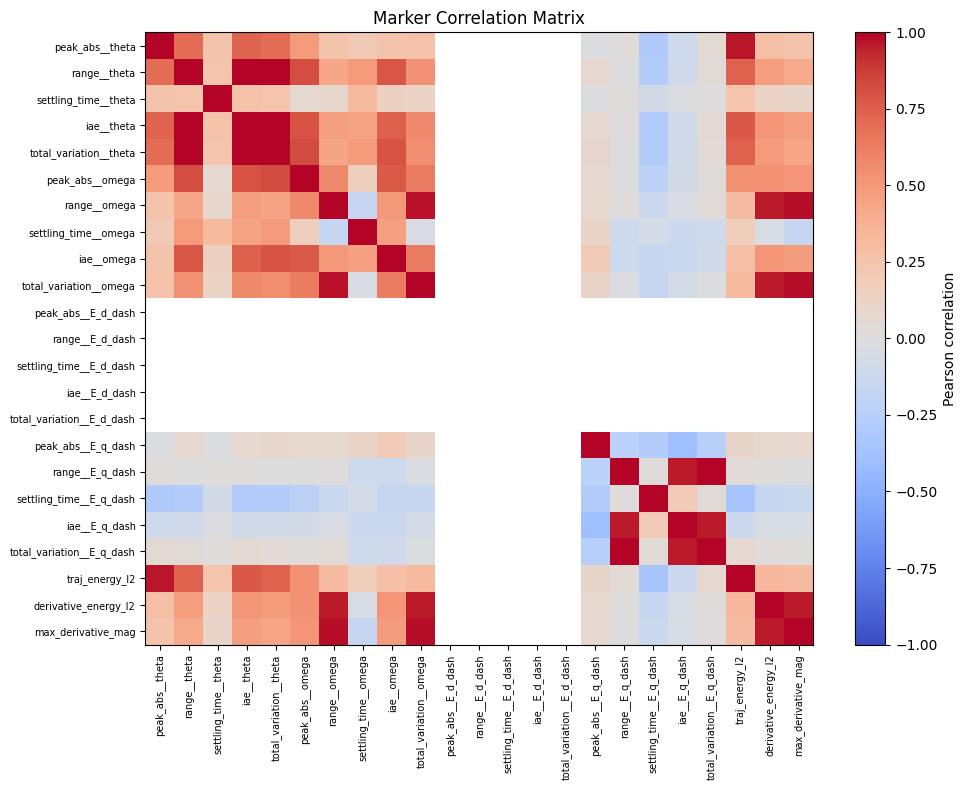

Highly correlated marker pairs (|rho| > 0.9): 13


|rho|
range__theta           total_variation__theta     0.999648
range__E_q_dash        total_variation__E_q_dash  0.997117
iae__theta             total_variation__theta     0.994893
range__theta           iae__theta                 0.993738
range__omega           max_derivative_mag         0.982170
total_variation__omega max_derivative_mag         0.981895
range__omega           total_variation__omega     0.974937
peak_abs__theta        traj_energy_l2             0.963345
range__omega           derivative_energy_l2       0.960204
range__E_q_dash        iae__E_q_dash              0.957957
derivative_energy_l2   max_derivative_mag         0.957377
iae__E_q_dash          total_variation__E_q_dash  0.955116
total_variation__omega derivative_energy_l2       0.954691

Redundant marker groups:
1. ['peak_abs__theta', 'traj_energy_l2']
2. ['iae__theta', 'range__theta', 'total_variation__theta']
3. ['derivative_energy_l2', 'max_derivative_mag', 'range__omega', 'total_variation__omega']
4. ['iae__E_q_dash', 'range__E_q_dash', 'total_variation__E_q_dash']


In [7]:
def find_redundant_groups(corr: pd.DataFrame, threshold: float = 0.90) -> list[list[str]]:
    cols = corr.columns.to_list()
    n = len(cols)

    # Build graph edges where |rho| > threshold (excluding diagonal)
    adj = {i: set() for i in range(n)}
    arr = corr.values
    for i in range(n):
        for j in range(i + 1, n):
            if abs(arr[i, j]) > threshold:
                adj[i].add(j)
                adj[j].add(i)

    # Connected components
    visited = set()
    groups = []
    for i in range(n):
        if i in visited or not adj[i]:
            continue
        stack = [i]
        comp = []
        while stack:
            u = stack.pop()
            if u in visited:
                continue
            visited.add(u)
            comp.append(cols[u])
            stack.extend(v for v in adj[u] if v not in visited)
        if len(comp) > 1:
            groups.append(sorted(comp))
    return groups


corr = marker_df.corr(method="pearson")
redundant_groups = find_redundant_groups(corr, threshold=REDUNDANCY_THRESHOLD)

fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(corr.values, vmin=-1.0, vmax=1.0, cmap="coolwarm", aspect="auto")
ax.set_title("Marker Correlation Matrix")
ax.set_xticks(range(len(marker_names)))
ax.set_yticks(range(len(marker_names)))
ax.set_xticklabels(marker_names, rotation=90, fontsize=7)
ax.set_yticklabels(marker_names, fontsize=7)
fig.colorbar(im, ax=ax, label="Pearson correlation")
fig.tight_layout()
plt.show()

high_pairs = (
    corr.abs()
    .where(np.triu(np.ones_like(corr, dtype=bool), k=1))
    .stack()
    .sort_values(ascending=False)
)
high_pairs = high_pairs[high_pairs > REDUNDANCY_THRESHOLD]

print(f"Highly correlated marker pairs (|rho| > {REDUNDANCY_THRESHOLD}): {len(high_pairs)}")
display(high_pairs.head(30).to_frame("|rho|"))

print("Redundant marker groups:")
if not redundant_groups:
    print("- None detected above threshold")
else:
    for i, grp in enumerate(redundant_groups, start=1):
        print(f"{i}. {grp}")


In [8]:
if DROP_REDUNDANT_MARKERS and redundant_groups:
    drop_cols = [grp[1:] for grp in redundant_groups]
    drop_cols = sorted(set(itertools.chain.from_iterable(drop_cols)))
    keep_cols = [c for c in marker_names if c not in drop_cols]
    marker_df_used = marker_df[keep_cols].copy()
    print(f"Dropped {len(drop_cols)} redundant markers. Using {len(keep_cols)} markers.")
else:
    marker_df_used = marker_df.copy()
    print(f"Using full marker set: {marker_df_used.shape[1]} markers")

X_used_std = StandardScaler().fit_transform(marker_df_used.values)
used_marker_names = marker_df_used.columns.to_list()


Using full marker set: 23 markers


## 4) Intrinsic Dimensionality Analysis (PCA)


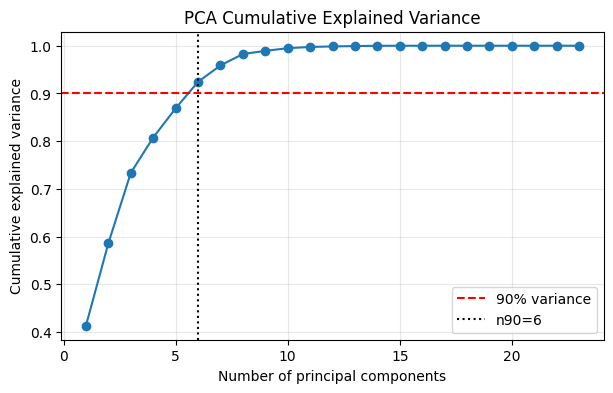

Components needed for 90% explained variance: 6

Top contributing markers for PC1 (absolute loading):


PC1
iae__theta              0.341456
total_variation__theta  0.336932
range__theta            0.334158
peak_abs__omega         0.309455
total_variation__omega  0.296895
iae__omega              0.288121
derivative_energy_l2    0.279336
range__omega            0.271222


Top contributing markers for PC2 (absolute loading):


PC2
iae__E_q_dash              0.545836
total_variation__E_q_dash  0.543271
range__E_q_dash            0.540752
range__omega               0.098351
max_derivative_mag         0.091658
derivative_energy_l2       0.086134
settling_time__omega      -0.140207
peak_abs__E_q_dash        -0.233090


Top contributing markers for PC3 (absolute loading):


PC3
max_derivative_mag      0.389087
range__omega            0.387245
derivative_energy_l2    0.347984
total_variation__omega  0.341965
range__theta           -0.221138
traj_energy_l2         -0.251667
peak_abs__theta        -0.274423
settling_time__omega   -0.345321

In [9]:
pca_full = PCA()
X_pca_full = pca_full.fit_transform(X_used_std)

expl = pca_full.explained_variance_ratio_
cum_expl = np.cumsum(expl)
n90 = int(np.searchsorted(cum_expl, 0.90) + 1)

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(np.arange(1, len(cum_expl) + 1), cum_expl, marker="o")
ax.axhline(0.90, color="r", linestyle="--", label="90% variance")
ax.axvline(n90, color="k", linestyle=":", label=f"n90={n90}")
ax.set_xlabel("Number of principal components")
ax.set_ylabel("Cumulative explained variance")
ax.set_title("PCA Cumulative Explained Variance")
ax.grid(alpha=0.3)
ax.legend()
plt.show()

print(f"Components needed for 90% explained variance: {n90}")

loadings = pd.DataFrame(
    pca_full.components_.T,
    index=used_marker_names,
    columns=[f"PC{i+1}" for i in range(len(used_marker_names))],
)

for pc in ["PC1", "PC2", "PC3"]:
    if pc in loadings.columns:
        print(f"\nTop contributing markers for {pc} (absolute loading):")
        top = loadings[pc].abs().sort_values(ascending=False).head(8).index
        display(loadings.loc[top, [pc]].sort_values(pc, ascending=False))


### Interpretation Prompt

Use the `n90` result and PC loadings above to decide whether trajectory realizations occupy:
- a compact low-dimensional manifold (often 2-3 dominant axes), or
- a broader higher-dimensional structure.

In smooth small-signal settings, dominant PCs often reflect amplitude scaling, decay timescale, and activity level rather than regime jumps.


## 5) Density Analysis in Marker Space


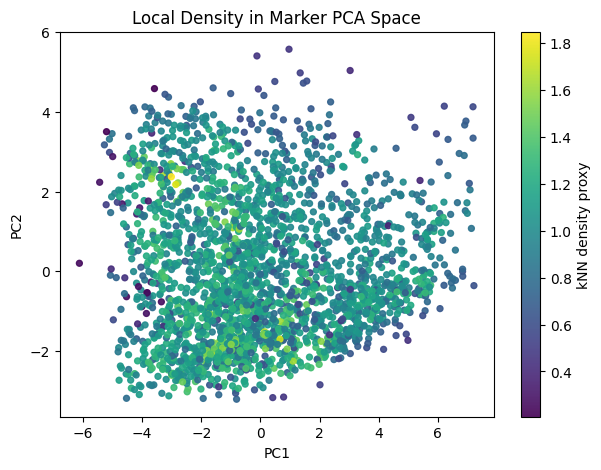

Dense region threshold (top 20% density): density >= 1.2153e+00
Sparse region threshold (bottom 20% density): density <= 8.5553e-01
Num dense trajectories: 480
Num sparse trajectories: 480


In [10]:
# Use PCA space truncated to n90 dimensions for geometry operations.
X_red = X_pca_full[:, :n90]

k_density = min(DENSITY_K, max(2, len(X_red) - 1))
nn = NearestNeighbors(n_neighbors=k_density)
nn.fit(X_red)
dists, _ = nn.kneighbors(X_red)

# Density proxy: inverse mean kNN distance (exclude the first neighbor = self, dist=0)
mean_knn_dist = dists[:, 1:].mean(axis=1)
density = 1.0 / (mean_knn_dist + 1e-12)

fig, ax = plt.subplots(figsize=(7, 5))
sc = ax.scatter(X_red[:, 0], X_red[:, 1], c=density, s=18, cmap="viridis", alpha=0.9)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("Local Density in Marker PCA Space")
fig.colorbar(sc, ax=ax, label="kNN density proxy")
plt.show()

q_lo, q_hi = np.quantile(density, [0.2, 0.8])
print(f"Dense region threshold (top 20% density): density >= {q_hi:.4e}")
print(f"Sparse region threshold (bottom 20% density): density <= {q_lo:.4e}")
print(f"Num dense trajectories: {(density >= q_hi).sum()}")
print(f"Num sparse trajectories: {(density <= q_lo).sum()}")


## 6) Clustering in Reduced Marker Space (Continuum Interpretation)


Selected k = 5 (heuristic: balance + compactness)
Cluster sizes:


count
0    470
1    424
2    412
3    420
4    674

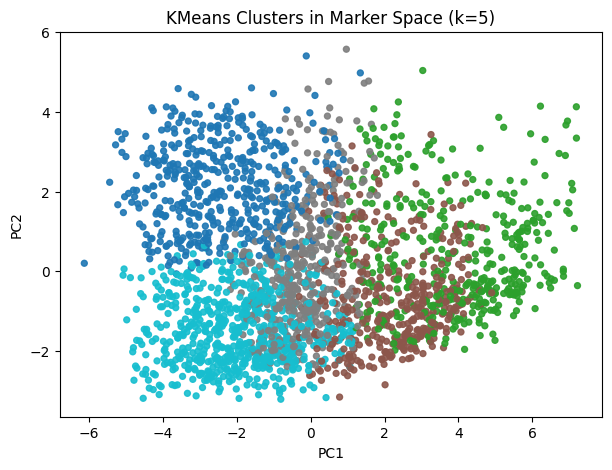

Marker summary per cluster (mean/std):


peak_abs__theta           range__theta           settling_time__theta  \
                   mean       std         mean       std                 mean   
cluster                                                                         
0              0.498580  0.275958     0.267450  0.179229             0.914153   
1              1.354908  0.428034     0.813701  0.206555             0.942078   
2              1.346927  0.374746     0.908024  0.149708             0.935743   
3              1.582913  0.266872     0.521125  0.076708             0.944719   
4              0.620235  0.348230     0.279278  0.152032             0.919013   

                  iae__theta           total_variation__theta            \
              std       mean       std                   mean       std   
cluster                                                                   
0        0.079533   0.121240  0.084693               0.273485  0.176034   
1        0.005895   0.416891  0.109510               0.823810  0.201901   
2        0.006132   0.434563  0.084464               0.908085  0.149603   
3        0.006792   0.261309  0.041316               0.523460  0.075383   
4        0.074129   0.128497  0.072612               0.285441  0.149238   

        peak_abs__omega           range__omega           settling_time__omega  \
                   mean       std         mean       std                 mean   
cluster                                                                         
0              0.584393  0.237279     0.585896  0.306483             0.712643   
1              1.040209  0.158808     1.614061  0.252834             0.804146   
2              1.079396  0.125369     0.686528  0.254387             0.934801   
3              0.645202  0.120688     0.576834  0.341533             0.802379   
4              0.569308  0.225604     0.605080  0.329075             0.763298   

                  iae__omega           total_variation__omega            \
              std       mean       std                   mean       std   
cluster                                                                   
0        0.247881   0.099387  0.052986               0.670437  0.351582   
1        0.138736   0.214430  0.046671               1.916404  0.283737   
2        0.026325   0.225465  0.043912               1.003925  0.307379   
3        0.202554   0.091310  0.034087               0.659126  0.365360   
4        0.198108   0.103064  0.048106               0.707440  0.375701   

        peak_abs__E_d_dash      range__E_d_dash       
                      mean  std            mean  std  
cluster                                               
0                      0.0  0.0             0.0  0.0  
1                      0.0  0.0             0.0  0.0  
2                      0.0  0.0             0.0  0.0  
3                      0.0  0.0             0.0  0.0  
4                      0.0  0.0             0.0  0.0

In [11]:
cluster_results = []
for k in K_RANGE:
    if k >= len(X_red):
        continue
    km = KMeans(n_clusters=k, random_state=RANDOM_SEED, n_init=20)
    labels = km.fit_predict(X_red)

    sizes = pd.Series(labels).value_counts().sort_index()
    imbalance = float(sizes.max() / max(1, sizes.min()))
    inertia = float(km.inertia_)
    cluster_results.append((k, inertia, imbalance, sizes, labels, km))

if not cluster_results:
    raise ValueError("No valid clustering result. Reduce k range or load more trajectories.")

# Pick k by smallest inertia among moderately balanced partitions as a practical heuristic.
cluster_results_sorted = sorted(cluster_results, key=lambda x: (x[2], x[1]))
best_k, best_inertia, best_imbalance, best_sizes, cluster_labels, best_km = cluster_results_sorted[0]

print(f"Selected k = {best_k} (heuristic: balance + compactness)")
print("Cluster sizes:")
display(best_sizes.to_frame("count"))

fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(X_red[:, 0], X_red[:, 1], c=cluster_labels, cmap="tab10", s=18, alpha=0.9)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title(f"KMeans Clusters in Marker Space (k={best_k})")
plt.show()

marker_stats_by_cluster = marker_df_used.copy()
marker_stats_by_cluster["cluster"] = cluster_labels
summary = marker_stats_by_cluster.groupby("cluster").agg(["mean", "std"]) 
print("Marker summary per cluster (mean/std):")
display(summary.iloc[:, : min(24, summary.shape[1])])


### Typical Trajectory Realizations Per Cluster

Representative trajectories are selected as **medoids in reduced marker-PCA space** (nearest sample to cluster centroid).
For each cluster, we also show the nearest typical neighbors to the centroid.


Typical trajectory realizations per cluster (marker-space medoid + nearest neighbors):


cluster  cluster_size  representative_idx           typical_indices
0        0           470                 968    [968, 1906, 1547, 823]
1        1           424                1658   [1658, 697, 1495, 1009]
2        2           412                1414  [1414, 2008, 1545, 2387]
3        3           420                 723    [723, 406, 1725, 1830]
4        4           674                  10      [10, 709, 747, 1994]

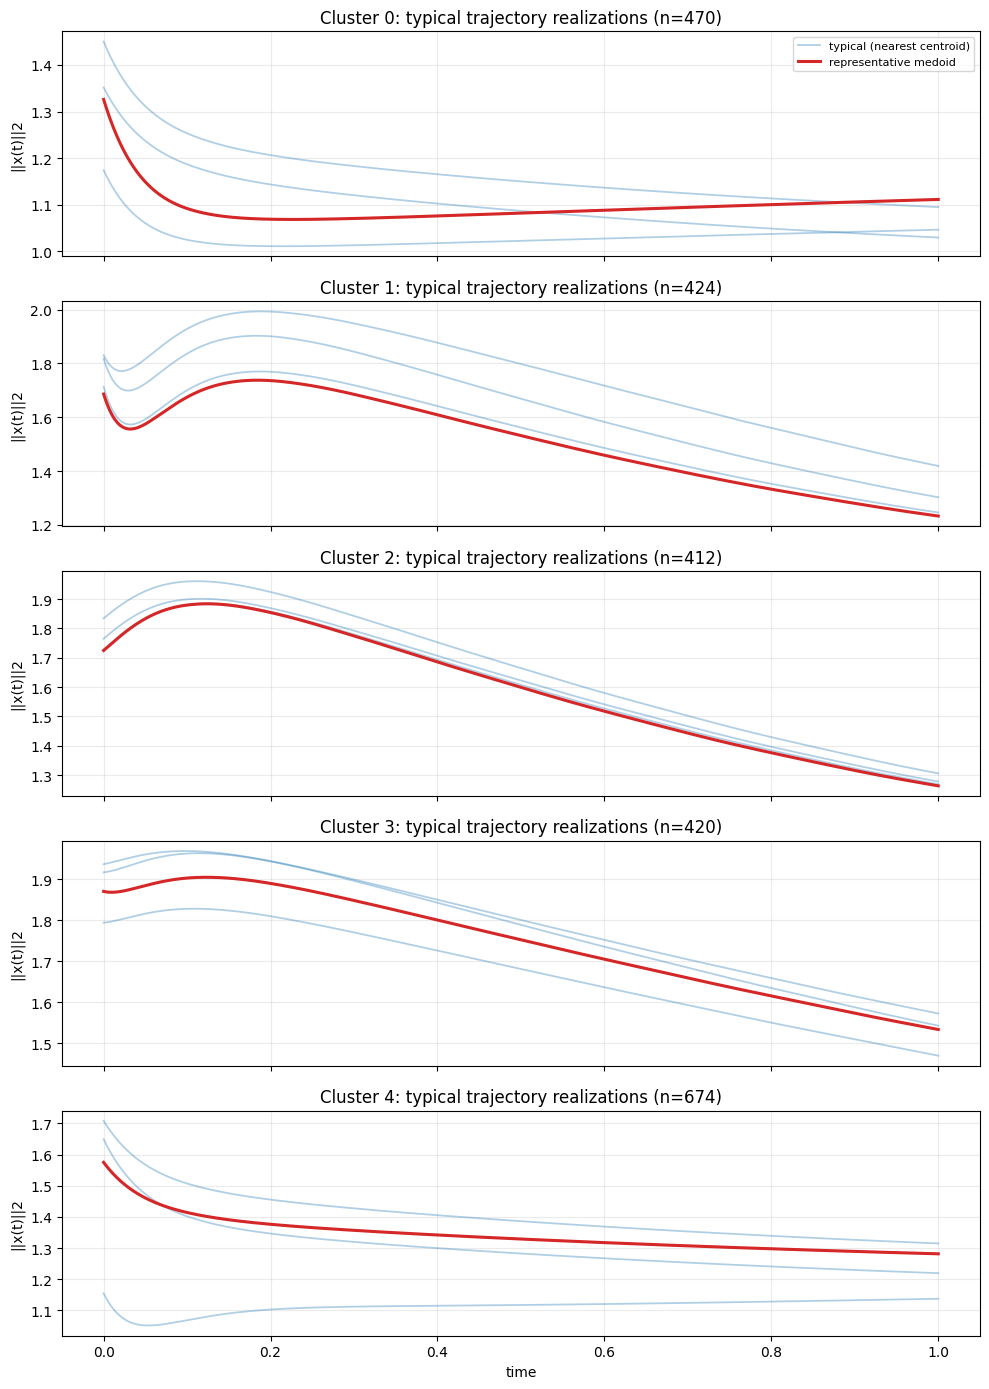

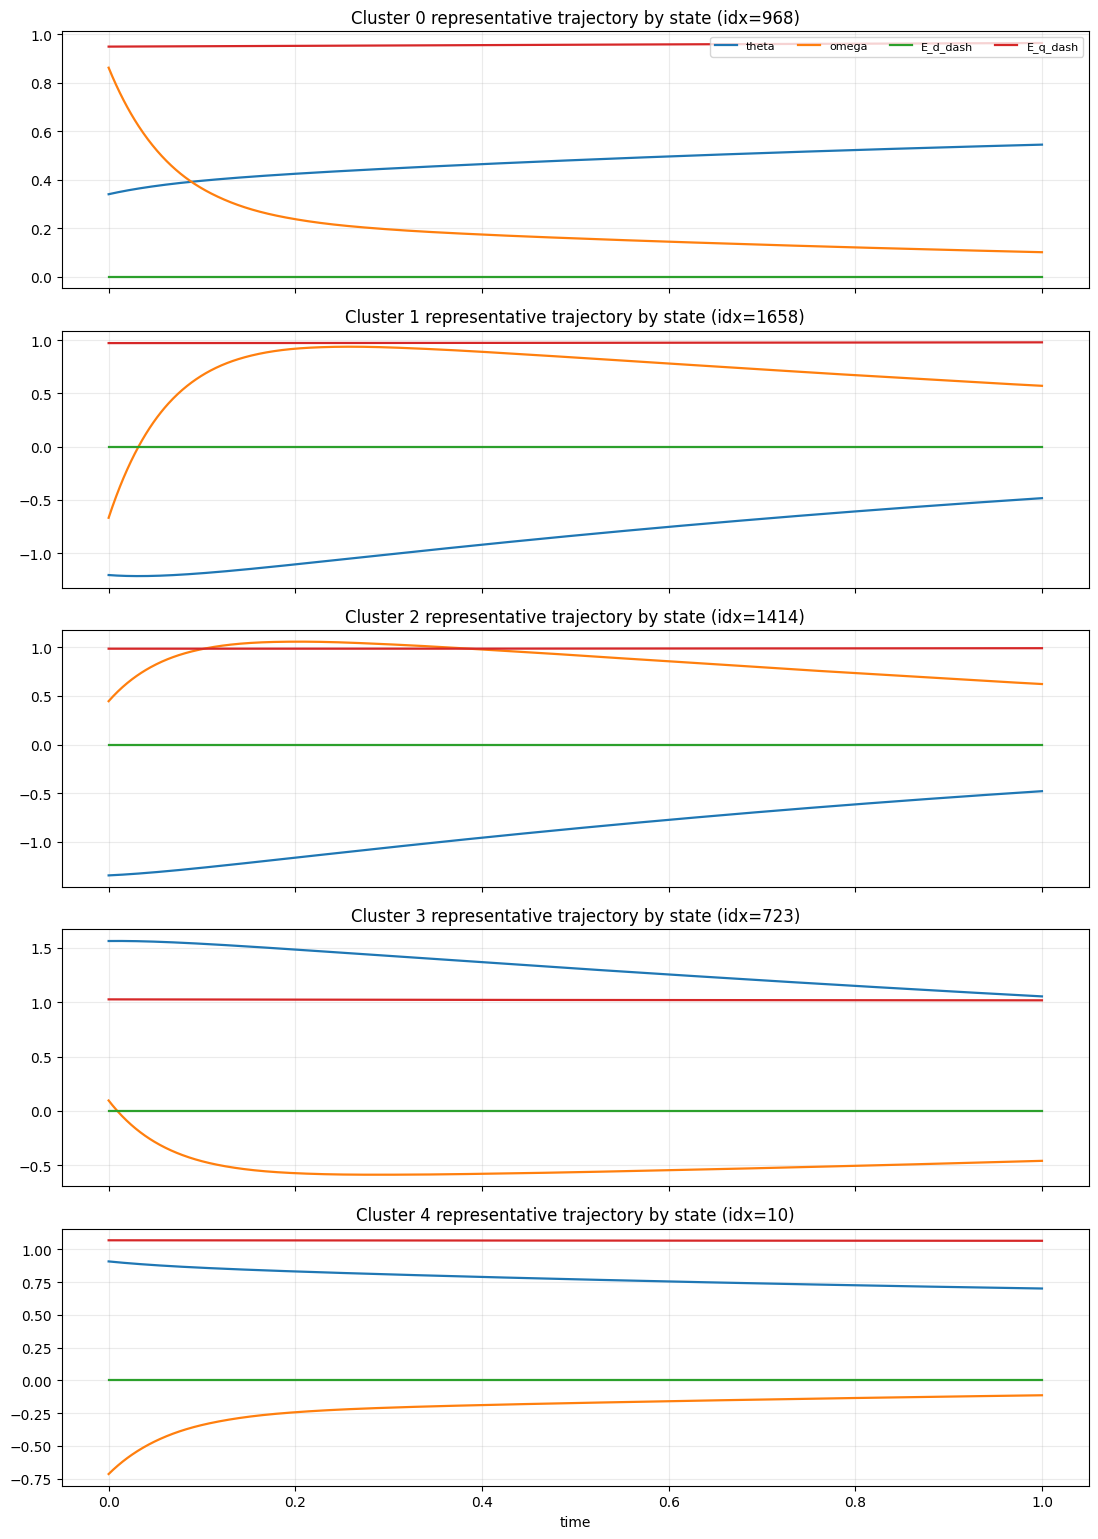

In [12]:
REP_NEIGHBORS = 4   # number of typical trajectories shown per cluster
REP_STATES_MAX = 4  # number of states shown in representative-state plots

unique_clusters = np.sort(np.unique(cluster_labels))
rep_rows = []
rep_indices = {}
rep_neighbor_indices = {}

for c in unique_clusters:
    idx = np.where(cluster_labels == c)[0]
    Xc = X_red[idx]
    centroid = Xc.mean(axis=0)
    d = np.linalg.norm(Xc - centroid, axis=1)
    order_local = np.argsort(d)

    rep_idx = int(idx[order_local[0]])
    k_show = min(REP_NEIGHBORS, len(idx))
    near_idx = idx[order_local[:k_show]].astype(int)

    rep_indices[int(c)] = rep_idx
    rep_neighbor_indices[int(c)] = near_idx

    rep_rows.append({
        "cluster": int(c),
        "cluster_size": int(len(idx)),
        "representative_idx": rep_idx,
        "typical_indices": near_idx.tolist(),
    })

rep_df = pd.DataFrame(rep_rows).sort_values("cluster")
print("Typical trajectory realizations per cluster (marker-space medoid + nearest neighbors):")
display(rep_df)

# Plot 1: trajectory L2 norm for typical trajectories in each cluster.
traj_norm = np.linalg.norm(trajs, axis=2)  # (N, T)
fig, axes = plt.subplots(len(unique_clusters), 1, figsize=(10, 2.8 * len(unique_clusters)), sharex=True)
axes = np.atleast_1d(axes)

for ax, c in zip(axes, unique_clusters):
    near_idx = rep_neighbor_indices[int(c)]
    rep_idx = rep_indices[int(c)]

    for ii, idx in enumerate(near_idx):
        lbl = "typical (nearest centroid)" if ii == 0 else None
        ax.plot(time_grid, traj_norm[idx], color="tab:blue", alpha=0.35, linewidth=1.3, label=lbl)

    ax.plot(time_grid, traj_norm[rep_idx], color="tab:red", linewidth=2.2, label="representative medoid")
    ax.set_ylabel("||x(t)||2")
    ax.set_title(f"Cluster {int(c)}: typical trajectory realizations (n={np.sum(cluster_labels==c)})")
    ax.grid(alpha=0.25)

axes[-1].set_xlabel("time")
handles, labels = axes[0].get_legend_handles_labels()
if handles:
    axes[0].legend(loc="best", fontsize=8)
fig.tight_layout()
plt.show()

# Plot 2: representative medoid trajectories on selected states.
plot_state_idx = list(range(min(REP_STATES_MAX, n_states)))
plot_state_names = [state_names[i] for i in plot_state_idx]

fig, axes = plt.subplots(len(unique_clusters), 1, figsize=(11, 3.1 * len(unique_clusters)), sharex=True)
axes = np.atleast_1d(axes)

for ax, c in zip(axes, unique_clusters):
    rep_idx = rep_indices[int(c)]
    for i_state, s_name in zip(plot_state_idx, plot_state_names):
        ax.plot(time_grid, trajs[rep_idx, :, i_state], linewidth=1.6, label=s_name)
    ax.set_title(f"Cluster {int(c)} representative trajectory by state (idx={rep_idx})")
    ax.grid(alpha=0.25)

axes[-1].set_xlabel("time")
axes[0].legend(loc="upper right", ncol=min(4, len(plot_state_names)), fontsize=8)
fig.tight_layout()
plt.show()


### Cluster Interpretation Note

Interpret these clusters as **bins along a smooth behavioral continuum** in marker space.
They summarize local neighborhoods of similar trajectory geometry, not separate dynamical regimes.


## 7) Map Marker Structure Back to IC Space


In [13]:
ic_df = pd.DataFrame(ics, columns=ic_names)
ic_df["cluster"] = cluster_labels

ic_mean = ic_df.groupby("cluster")[ic_names].mean()
ic_var = ic_df.groupby("cluster")[ic_names].var(ddof=0)

print("IC means by cluster:")
display(ic_mean)
print("IC variances by cluster:")
display(ic_var)


IC means by cluster:


theta     omega  E_d_dash  E_q_dash        Vs  theta_vs
cluster                                                            
0        0.107489  0.050937       0.0  0.940168  1.000294  0.000023
1       -0.939761 -0.400613       0.0  1.007890  0.999266  0.025962
2       -1.346866  0.456100       0.0  1.004358  1.000867  0.015111
3        1.555195 -0.135384       0.0  0.999795  1.000609 -0.017648
4        0.370412  0.022044       0.0  1.034223  0.999346 -0.014592

IC variances by cluster:


theta     omega  E_d_dash  E_q_dash        Vs  theta_vs
cluster                                                            
0        0.289823  0.331412       0.0  0.000703  0.000846  0.031458
1        1.109511  0.294403       0.0  0.003369  0.000837  0.029904
2        0.140145  0.113895       0.0  0.002865  0.000833  0.031201
3        0.150590  0.240455       0.0  0.003672  0.000831  0.028665
4        0.351372  0.309320       0.0  0.001502  0.000823  0.028170

Excluded by name: ['E_d_dash']


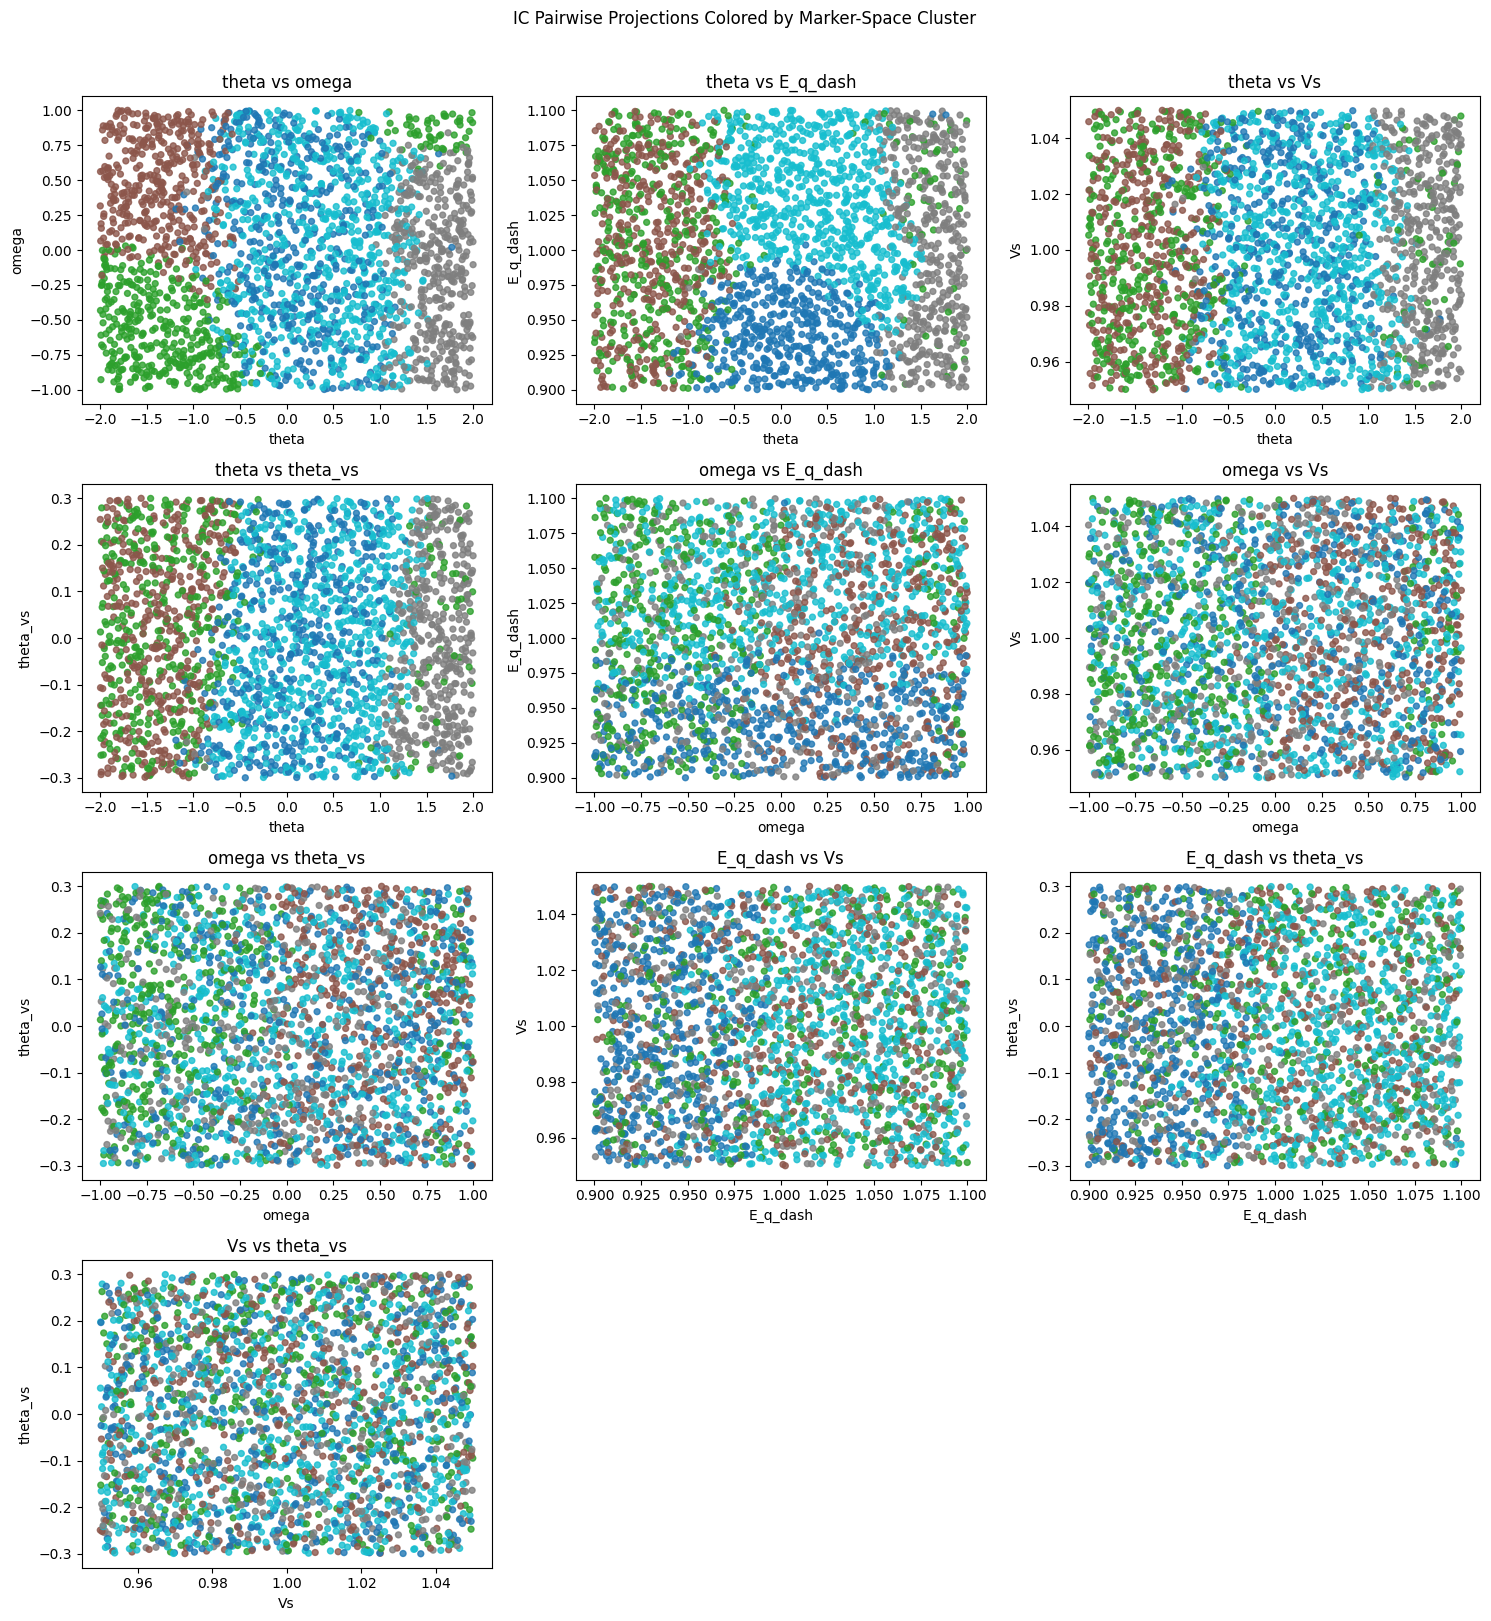

In [14]:
# Pairwise IC projections colored by cluster.
# Exclude constant IC dimensions (e.g., E_d_dash fixed at 0) and explicit E_d_dash.
constant_tol = 1e-12
explicit_exclude = {"E_d_dash", "e_d_dash", "E_D_dash", "E_D_DASH"}

variable_ic_names = []
excluded_constant = []
excluded_named = []

for name in ic_names:
    if name in explicit_exclude:
        excluded_named.append(name)
        continue
    if float(ic_df[name].std(ddof=0)) <= constant_tol:
        excluded_constant.append(name)
        continue
    variable_ic_names.append(name)

if excluded_named:
    print(f"Excluded by name: {excluded_named}")
if excluded_constant:
    print(f"Excluded constant IC dimensions: {excluded_constant}")

plot_ic_names = variable_ic_names[: min(5, len(variable_ic_names))]
pairs = list(itertools.combinations(plot_ic_names, 2))

if not pairs:
    print("Not enough non-constant IC dimensions for pairwise projection plots.")
else:
    n_cols = 3
    n_rows = int(np.ceil(len(pairs) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = np.atleast_1d(axes).ravel()

    for ax, (a, b) in zip(axes, pairs):
        ax.scatter(ic_df[a], ic_df[b], c=cluster_labels, cmap="tab10", s=18, alpha=0.8)
        ax.set_xlabel(a)
        ax.set_ylabel(b)
        ax.set_title(f"{a} vs {b}")

    for ax in axes[len(pairs):]:
        ax.axis("off")

    fig.suptitle("IC Pairwise Projections Colored by Marker-Space Cluster", y=1.01)
    fig.tight_layout()
    plt.show()


Interpretation prompt:
- If clusters localize to compact IC regions, behavior diversity is linked to specific IC subdomains.
- If clusters overlap smoothly in IC projections, behavior varies continuously across IC space.


## 8) Diversity-Oriented Sampling Simulation (Dry Run)


In [15]:
# Sampling is performed on reduced marker coordinates X_red, without generating new trajectories.

rng = np.random.default_rng(RANDOM_SEED)


def farthest_point_sampling(X: np.ndarray, n_select: int, start_idx: int = 0) -> np.ndarray:
    n = X.shape[0]
    n_select = min(max(1, n_select), n)

    selected = [int(start_idx % n)]
    min_d = np.linalg.norm(X - X[selected[0]], axis=1)

    while len(selected) < n_select:
        idx = int(np.argmax(min_d))
        selected.append(idx)
        d_new = np.linalg.norm(X - X[idx], axis=1)
        min_d = np.minimum(min_d, d_new)
    return np.array(selected, dtype=int)


def density_sparse_first_sampling(density_vec: np.ndarray, n_select: int) -> np.ndarray:
    n = density_vec.shape[0]
    n_select = min(max(1, n_select), n)
    # Lower density first -> prioritize underrepresented regions
    order = np.argsort(density_vec)
    return order[:n_select]


def random_sampling(n_total: int, n_select: int, rng_obj: np.random.Generator) -> np.ndarray:
    n_select = min(max(1, n_select), n_total)
    return rng_obj.choice(n_total, size=n_select, replace=False)


def lhs_order_sampling(n_total: int, n_select: int) -> np.ndarray:
    # For raw+shuffle=False this approximates original LHS ordering in stored dataset.
    return np.arange(min(max(1, n_select), n_total), dtype=int)


def coverage_metrics(X: np.ndarray, selected_idx: np.ndarray) -> dict[str, float]:
    S = X[selected_idx]
    D_all_to_sel = pairwise_distances(X, S)
    min_to_sel = D_all_to_sel.min(axis=1)
    coverage_mean_min = float(min_to_sel.mean())

    if len(selected_idx) <= 1:
        selected_avg_min = 0.0
    else:
        D_sel = pairwise_distances(S, S)
        np.fill_diagonal(D_sel, np.inf)
        selected_avg_min = float(np.min(D_sel, axis=1).mean())

    return {
        "coverage_mean_min_dist": coverage_mean_min,
        "selected_avg_min_dist": selected_avg_min,
    }


In [16]:
valid_n_values = [n for n in SAMPLING_N_VALUES if n < len(X_red)]
if not valid_n_values:
    valid_n_values = [min(len(X_red) - 1, max(8, len(X_red) // 10))]

rows = []
for n_sel in valid_n_values:
    idx_fps = farthest_point_sampling(X_red, n_sel, start_idx=0)
    idx_dens = density_sparse_first_sampling(density, n_sel)
    idx_rand = random_sampling(len(X_red), n_sel, rng)
    idx_lhs = lhs_order_sampling(len(X_red), n_sel)

    for strategy, idx in [
        ("farthest_point", idx_fps),
        ("density_sparse_first", idx_dens),
        ("random", idx_rand),
        ("lhs_order", idx_lhs),
    ]:
        m = coverage_metrics(X_red, idx)
        rows.append({"n_selected": n_sel, "strategy": strategy, **m})

sampling_df = pd.DataFrame(rows)
display(sampling_df.pivot(index="n_selected", columns="strategy", values="coverage_mean_min_dist"))
display(sampling_df.pivot(index="n_selected", columns="strategy", values="selected_avg_min_dist"))


strategy    density_sparse_first  farthest_point  lhs_order    random
n_selected                                                           
16                      9.174782        2.878429   2.319949  2.463860
32                      4.558331        2.171328   1.896487  1.947184
64                      3.615394        1.644963   1.518917  1.576282
128                     2.604697        1.182358   1.180746  1.219452
256                     1.807952        0.880512   0.927002  0.944592
512                     1.142454        0.614772   0.667768  0.681454

strategy    density_sparse_first  farthest_point  lhs_order    random
n_selected                                                           
16                      1.401518        5.393672   2.591685  3.026513
32                      1.998777        4.034892   2.092186  1.830130
64                      1.407959        3.143967   1.668363  1.433785
128                     1.263784        2.309035   1.385577  1.368510
256                     1.054307        1.750182   1.084599  1.031091
512                     0.903107        1.308069   0.859185  0.870353

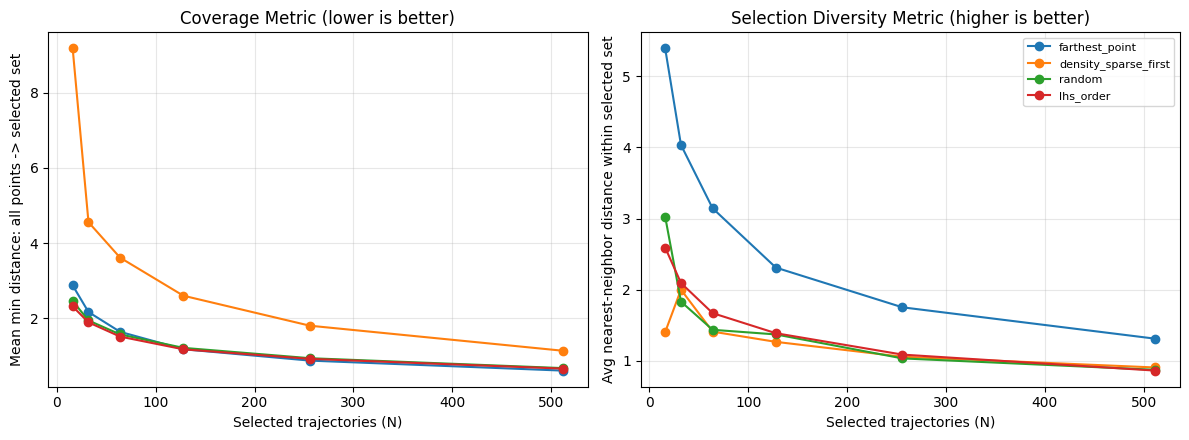

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))

for strategy in sampling_df["strategy"].unique():
    sub = sampling_df[sampling_df["strategy"] == strategy].sort_values("n_selected")
    axes[0].plot(sub["n_selected"], sub["coverage_mean_min_dist"], marker="o", label=strategy)
    axes[1].plot(sub["n_selected"], sub["selected_avg_min_dist"], marker="o", label=strategy)

axes[0].set_xlabel("Selected trajectories (N)")
axes[0].set_ylabel("Mean min distance: all points -> selected set")
axes[0].set_title("Coverage Metric (lower is better)")
axes[0].grid(alpha=0.3)

axes[1].set_xlabel("Selected trajectories (N)")
axes[1].set_ylabel("Avg nearest-neighbor distance within selected set")
axes[1].set_title("Selection Diversity Metric (higher is better)")
axes[1].grid(alpha=0.3)

axes[1].legend(loc="best", fontsize=8)
fig.tight_layout()
plt.show()


## 9) Conclusion (Fill with Run-Specific Findings)

Use the computed tables and plots to summarize:

1. Effective dimensionality:
- `n90 = ...` components needed for 90% variance.
- Trajectory marker geometry appears low-dimensional or higher-dimensional.

2. Redundancy in current LHS dataset:
- Number of highly correlated marker pairs and redundant groups.
- Whether many trajectories lie in dense/redundant marker regions.

3. Cluster interpretation:
- Clusters behave as smooth continuum bins or show sharp separation.
- Mapping to IC space indicates localized IC pockets or gradual variation.

4. Directed sampling design implications:
- Whether to prioritize cluster balancing, pure diversity maximization (farthest-point), sparse-region targeting (density-based), or a hybrid schedule.

Framing: **behavioral manifold coverage + redundancy reduction**, not regime discovery.
